# Add BED to ENSG_TPM

In [1]:
library(tidyverse)
library(ggplot2)
library(clusterProfiler)
library(biomaRt)
print("Loaded.")

setwd("/data/hodges_lab/Tim/nnRNA_TPM_EHGM/reference_files/")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



clusterProfiler v4.2.0  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:purrr’:

    simplify


The following object is masked from ‘package:stats’:

    filter




[1] "Loaded."


## HepG2

### Average reps

In [2]:
# Read in ENCFF974MUO.tsv ENCFF649AHO.tsv
HepG2_ENSG_file_in_1 <- read_tsv("./ENCFF974MUO.tsv", col_names=TRUE, skip=0)
HepG2_ENSG_file_in_2 <- read_tsv("./ENCFF649AHO.tsv", col_names=TRUE, skip=0) 

Rows: 58540 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (2): gene_id, transcript_id(s)
dbl (13): length, effective_length, expected_count, TPM, FPKM, posterior_mea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 58540 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (2): gene_id, transcript_id(s)
dbl (13): length, effective_length, expected_count, TPM, FPKM, posterior_mea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
# Filter to keep just ENSG rows
HepG2_ENSG_only_1 <- HepG2_ENSG_file_in_1 %>%
    filter("ENSG"==substr(gene_id, 1, 4))
HepG2_ENSG_only_2 <- HepG2_ENSG_file_in_2 %>%
    filter("ENSG"==substr(gene_id, 1, 4))

# Isolate columns we want: ENSEMBL TPM
HepG2_ENSG_TPM_1 <- HepG2_ENSG_only_1 %>%
    dplyr::select(gene_id, TPM) %>% # isolate gene_id_clean and TPM columns
    magrittr::set_colnames(c("ENSEMBL", "TPM")) # Rename these for easier merging and readibility 
HepG2_ENSG_TPM_2 <- HepG2_ENSG_only_2 %>%
    dplyr::select(gene_id, TPM) %>% # isolate gene_id_clean and TPM columns
    magrittr::set_colnames(c("ENSEMBL", "TPM")) # Rename these for easier merging and readibility 


# Average reps
HepG2_ENSG_TPM_merge12 <- merge(HepG2_ENSG_TPM_1, HepG2_ENSG_TPM_2, by = "ENSEMBL") %>% as_tibble()

HepG2_ENSG_TPM_avg12 <- HepG2_ENSG_TPM_merge12 %>% dplyr::mutate(TPM = rowMeans(dplyr::select(., TPM.x:TPM.y))) %>% dplyr::select(ENSEMBL, TPM)

In [4]:
write_tsv(HepG2_ENSG_TPM_avg12, "HepG2_ENSG_TPM_avg12.txt", col_names = TRUE)

### Biomart

In [5]:
# define biomart object
# mart <- useMart(biomart = "ensembl", dataset = "hsapiens_gene_ensembl")
mart <- useMart(biomart="ENSEMBL_MART_ENSEMBL", host="grch37.ensembl.org", path="/biomart/martservice", dataset="hsapiens_gene_ensembl")

ENSEMBL_to_GENESYMBOL <- getBM(attributes=c("ensembl_gene_id_version", "hgnc_symbol", "chromosome_name", "start_position", "end_position","strand"), filters = "ensembl_gene_id_version", values = HepG2_ENSG_TPM_avg12$ENSEMBL, mart= mart)

Warning message:
“Ensembl will soon enforce the use of https.
Ensure the 'host' argument includes "https://"”


### Convert ENSEMBL to GENE SYMBOL

In [6]:
nrow(HepG2_ENSG_TPM_avg12)
head(HepG2_ENSG_TPM_avg12, 3)

[1] 57820

ENSEMBL,TPM
<chr>,<dbl>
ENSG00000000003.10,40.355
ENSG00000000005.5,0.000
ENSG00000000419.8,79.980


In [7]:
HepG2_ENSG_TPM_avg12_noVersion <- HepG2_ENSG_TPM_avg12 %>% mutate(ENSG = gsub("\\..*", "", ENSEMBL))

In [8]:
Liver_ENSEMBLnoVersion_to_GENESYMBOL <- getBM(attributes=c("ensembl_gene_id", "hgnc_symbol", "chromosome_name", "start_position", "end_position","strand"), filters = "ensembl_gene_id", values = HepG2_ENSG_TPM_avg12_noVersion$ENSG, mart= mart)

nrow(Liver_ENSEMBLnoVersion_to_GENESYMBOL)
Liver_ENSEMBLnoVersion_to_GENESYMBOL

[1] 57849

ensembl_gene_id,hgnc_symbol,chromosome_name,start_position,end_position,strand
<chr>,<chr>,<chr>,<int>,<int>,<int>
ENSG00000000003,TSPAN6,X,99883667,99894988,-1
ENSG00000000005,TNMD,X,99839799,99854882,1
ENSG00000000419,DPM1,20,49551404,49575092,-1
ENSG00000000457,SCYL3,1,169818772,169863408,-1
ENSG00000000460,C1orf112,1,169631245,169823221,1
ENSG00000000938,FGR,1,27938575,27961788,-1
ENSG00000000971,CFH,1,196621008,196716634,1
ENSG00000001036,FUCA2,6,143815948,143832827,-1
ENSG00000001084,GCLC,6,53362139,53481768,-1


In [9]:
Liver_ENSEMBLnoVersion_to_GENESYMBOL_emptyHGNC <- Liver_ENSEMBLnoVersion_to_GENESYMBOL %>% filter(hgnc_symbol=="")
Liver_ENSEMBLnoVersion_to_GENESYMBOL_hasHGNC <- Liver_ENSEMBLnoVersion_to_GENESYMBOL %>% filter(hgnc_symbol!="")

nrow(Liver_ENSEMBLnoVersion_to_GENESYMBOL)
nrow(Liver_ENSEMBLnoVersion_to_GENESYMBOL_hasHGNC)
nrow(Liver_ENSEMBLnoVersion_to_GENESYMBOL_emptyHGNC)

write_tsv(Liver_ENSEMBLnoVersion_to_GENESYMBOL_hasHGNC, "Liver_ENSEMBLnoVersion_to_GENESYMBOL_hasHGNC.txt")
write_tsv(Liver_ENSEMBLnoVersion_to_GENESYMBOL_emptyHGNC, "Liver_ENSEMBLnoVersion_to_GENESYMBOL_emptyHGNC.txt")

[1] 57849

[1] 33662

[1] 24187

In [11]:
Liver_ENSEMBLnoVersion_to_GENESYMBOL_hasHGNC

ensembl_gene_id,hgnc_symbol,chromosome_name,start_position,end_position,strand
<chr>,<chr>,<chr>,<int>,<int>,<int>
ENSG00000000003,TSPAN6,X,99883667,99894988,-1
ENSG00000000005,TNMD,X,99839799,99854882,1
ENSG00000000419,DPM1,20,49551404,49575092,-1
ENSG00000000457,SCYL3,1,169818772,169863408,-1
ENSG00000000460,C1orf112,1,169631245,169823221,1
ENSG00000000938,FGR,1,27938575,27961788,-1
ENSG00000000971,CFH,1,196621008,196716634,1
ENSG00000001036,FUCA2,6,143815948,143832827,-1
ENSG00000001084,GCLC,6,53362139,53481768,-1


### Relink ENSEMBL_to_GENESYMBOL and ENCODE file

In [12]:
nrow(Liver_ENSEMBLnoVersion_to_GENESYMBOL_hasHGNC)
nrow(HepG2_ENSG_TPM_avg12)
head(Liver_ENSEMBLnoVersion_to_GENESYMBOL_hasHGNC, 3)
head(HepG2_ENSG_TPM_avg12_noVersion, 3)

[1] 33662

[1] 57820

,ensembl_gene_id,hgnc_symbol,chromosome_name,start_position,end_position,strand
,<chr>,<chr>,<chr>,<int>,<int>,<int>
1,ENSG00000000003,TSPAN6,X,99883667,99894988,-1
2,ENSG00000000005,TNMD,X,99839799,99854882,1
3,ENSG00000000419,DPM1,20,49551404,49575092,-1


ENSEMBL,TPM,ENSG
<chr>,<dbl>,<chr>
ENSG00000000003.10,40.355,ENSG00000000003
ENSG00000000005.5,0.000,ENSG00000000005
ENSG00000000419.8,79.980,ENSG00000000419


In [14]:
merge(Liver_ENSEMBLnoVersion_to_GENESYMBOL_hasHGNC, HepG2_ENSG_TPM_avg12_noVersion, by.x = "ensembl_gene_id", by.y = "ENSG")

ensembl_gene_id,hgnc_symbol,chromosome_name,start_position,end_position,strand,ENSEMBL,TPM
<chr>,<chr>,<chr>,<int>,<int>,<int>,<chr>,<dbl>
ENSG00000000003,TSPAN6,X,99883667,99894988,-1,ENSG00000000003.10,40.355
ENSG00000000005,TNMD,X,99839799,99854882,1,ENSG00000000005.5,0.000
ENSG00000000419,DPM1,20,49551404,49575092,-1,ENSG00000000419.8,79.980
ENSG00000000457,SCYL3,1,169818772,169863408,-1,ENSG00000000457.9,1.830
ENSG00000000460,C1orf112,1,169631245,169823221,1,ENSG00000000460.12,2.630
ENSG00000000938,FGR,1,27938575,27961788,-1,ENSG00000000938.8,0.000
ENSG00000000971,CFH,1,196621008,196716634,1,ENSG00000000971.11,0.500
ENSG00000001036,FUCA2,6,143815948,143832827,-1,ENSG00000001036.9,33.440
ENSG00000001084,GCLC,6,53362139,53481768,-1,ENSG00000001084.6,320.300


In [15]:
# merge, sort columns, sort BED coordinates
HepG2_ENSG_TPM_avg12_noVersion_hasHGNC <- merge(Liver_ENSEMBLnoVersion_to_GENESYMBOL_hasHGNC, HepG2_ENSG_TPM_avg12_noVersion, by.x = "ensembl_gene_id", by.y = "ENSG") %>% 
mutate(chromosome = paste0("chr", chromosome_name)) %>% 
dplyr::select(chromosome, start_position, end_position, TPM, strand, hgnc_symbol, ensembl_gene_id) %>% arrange(chromosome, start_position)

HepG2_ENSG_TPM_avg12_noVersion_hasHGNC

chromosome,start_position,end_position,TPM,strand,hgnc_symbol,ensembl_gene_id
<chr>,<int>,<int>,<dbl>,<int>,<chr>,<chr>
chr1,11869,14412,0.000,1,DDX11L1,ENSG00000223972
chr1,14363,29806,6.370,-1,WASH7P,ENSG00000227232
chr1,29554,31109,0.000,1,MIR1302-11,ENSG00000243485
chr1,29554,31109,0.000,1,MIR1302-10,ENSG00000243485
chr1,29554,31109,0.000,1,MIR1302-9,ENSG00000243485
chr1,29554,31109,0.000,1,MIR1302-2,ENSG00000243485
chr1,34554,36081,0.000,-1,FAM138A,ENSG00000237613
chr1,52473,54936,0.000,1,OR4G4P,ENSG00000268020
chr1,62948,63887,0.000,1,OR4G11P,ENSG00000240361


In [16]:
write_tsv(HepG2_ENSG_TPM_avg12_noVersion_hasHGNC, "HepG2_ENSG_TPM_avg12_noVersion_hasHGNC.txt", col_names = TRUE)

#### Adjust BED coordinates for TSS based on strand

In [17]:
HepG2_ENSG_TPM_avg12_noVersion_hasHGNC_TSSstart <- HepG2_ENSG_TPM_avg12_noVersion_hasHGNC %>% mutate(TSS_start = case_when(
    (strand == "1") ~ start_position,
    (strand == "-1") ~ end_position
)) %>% arrange(chromosome, start_position)
head(HepG2_ENSG_TPM_avg12_noVersion_hasHGNC_TSSstart, 3)

,chromosome,start_position,end_position,TPM,strand,hgnc_symbol,ensembl_gene_id,TSS_start
,<chr>,<int>,<int>,<dbl>,<int>,<chr>,<chr>,<int>
1,chr1,11869,14412,0.00,1,DDX11L1,ENSG00000223972,11869
2,chr1,14363,29806,6.37,-1,WASH7P,ENSG00000227232,29806
3,chr1,29554,31109,0.00,1,MIR1302-11,ENSG00000243485,29554


In [18]:
HepG2_ENSG_TPM_avg12_noVersion_hasHGNC_TSScoords <- HepG2_ENSG_TPM_avg12_noVersion_hasHGNC_TSSstart %>% dplyr::mutate(TSS_end = (TSS_start + 1)) %>% dplyr::select(chromosome, TSS_start, TSS_end, TPM, strand, hgnc_symbol, ensembl_gene_id) %>% dplyr::arrange(chromosome, TSS_start)

nrow(HepG2_ENSG_TPM_avg12_noVersion_hasHGNC_TSScoords)
head(HepG2_ENSG_TPM_avg12_noVersion_hasHGNC_TSScoords, 3)


[1] 33662

,chromosome,TSS_start,TSS_end,TPM,strand,hgnc_symbol,ensembl_gene_id
,<chr>,<int>,<dbl>,<dbl>,<int>,<chr>,<chr>
1,chr1,11869,11870,0,1,DDX11L1,ENSG00000223972
2,chr1,29554,29555,0,1,MIR1302-11,ENSG00000243485
3,chr1,29554,29555,0,1,MIR1302-10,ENSG00000243485


#### Filter for TPM

In [20]:
HepG2_ENSG_TPM_avg12_noVersion_hasHGNC_minTPM0 <- HepG2_ENSG_TPM_avg12_noVersion_hasHGNC_TSScoords %>% filter(TPM > 0)

write_tsv(HepG2_ENSG_TPM_avg12_noVersion_hasHGNC_minTPM0, "HepG2_ENSG_TPM_avg12_noVersion_hasHGNC_minTPM0.withHeaders.txt", col_names = TRUE)
write_tsv(HepG2_ENSG_TPM_avg12_noVersion_hasHGNC_minTPM0, "HepG2_ENSG_TPM_avg12_noVersion_hasHGNC_minTPM0.txt", col_names = FALSE)

# Get 2NN

In [1]:
HOME_DIR=/data/hodges_lab/Tim/nnRNA_TPM_EHGM/
mkdir -p ${HOME_DIR}
REF_DIR=${HOME_DIR}reference_files/

# Directory 
mkdir -p ${HOME_DIR}intermediate_files
cd ${HOME_DIR}intermediate_files

INTER_DIR=${HOME_DIR}intermediate_files/
REF_DIR=${HOME_DIR}reference_files/
OUT_DIR=${HOME_DIR}output_files/

echo "Done liver."

Done liver.


In [2]:
# Bcell 
bedtools sort -i ${REF_DIR}HepG2_ENSG_TPM_avg12_noVersion_hasHGNC_minTPM0.txt | awk 'BEGIN{OFS=FS="\t"}{print }' - > ${REF_DIR}HepG2_ENSG_TPM_avg12_noVersion_hasHGNC_minTPM0.sorted.txt

echo "Done."

Done.


In [3]:
# Initalize HMR files 
Liver_CLUSTERED_CS_FILE=/data/hodges_lab/Tim/finalAnalyses_HMRs/hp_lineage/HMRs/Liver_internalClusters_individualHMRs_cellspecific_hpl.txt
Liver_UNCLUSTERED_CS_FILE=/data/hodges_lab/Tim/finalAnalyses_HMRs/hp_lineage/HMRs/Liver_unclustered_cellspecific_hpl.txt

awk 'BEGIN{OFS=FS="\t"}{print $1,$2,$3,"Liver_ClusteredCS"}' ${Liver_CLUSTERED_CS_FILE} | bedtools sort -i - > ${INTER_DIR}Liver.clustered_cs.tmp_sorted.txt
awk 'BEGIN{OFS=FS="\t"}{print $1,$2,$3,"Liver_UnclusteredCS"}' ${Liver_UNCLUSTERED_CS_FILE} | bedtools sort -i - > ${INTER_DIR}Liver.unclustered_cs.tmp_sorted.txt

echo "Done."

Done.


In [ ]:
# Clusters contain cell specific 

In [4]:
## How many clusters are represented by the individual clustered cell specific HMRs
bedtools intersect -u -a /data/hodges_lab/Tim/finalAnalyses_HMRs/hp_lineage/HMRs/Liver_internalClusters_hpl.txt -b /data/hodges_lab/Tim/finalAnalyses_HMRs/hp_lineage/HMRs/Liver_internalClusters_individualHMRs_cellspecific_hpl.txt > ${INTER_DIR}Liver_internalClusters_hpl.containsCellSpecificHMR.txt

wc -l ${INTER_DIR}Liver_internalClusters_hpl.containsCellSpecificHMR.txt

awk 'BEGIN{OFS=FS="\t"}{print $1,$2,$3,"Bcell_ClusteredCS"}' ${INTER_DIR}Liver_internalClusters_hpl.containsCellSpecificHMR.txt | bedtools sort -i - > ${INTER_DIR}Liver_internalClusters_hpl.containsCellSpecificHMR.tmp_sorted.txt

798 /data/hodges_lab/Tim/nnRNA_TPM_EHGM/intermediate_files/Liver_internalClusters_hpl.containsCellSpecificHMR.txt


In [ ]:
# Clusters contain cell specific 

In [2]:
bedtools closest -d -k 2 -a ${INTER_DIR}Liver_internalClusters_hpl.containsCellSpecificHMR.tmp_sorted.txt -b ${REF_DIR}HepG2_ENSG_TPM_avg12_noVersion_hasHGNC_minTPM0.sorted.txt > ${INTER_DIR}Liver_clusters_containsCS.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.txt

echo "Done."

Done.


In [3]:
# bedtools closest -d -k 2 -a ${INTER_DIR}Bcell.clustered_cs.tmp_sorted.txt -b ${REF_DIR}GM_ENSGGENESYMBOL_minTPM0.sorted.txt > ${INTER_DIR}Bcell_clustered_cellspecific.2NN.GM_ENSGGENESYMBOL_minTPM0.txt

bedtools closest -d -k 2 -a ${INTER_DIR}Liver.unclustered_cs.tmp_sorted.txt -b ${REF_DIR}HepG2_ENSG_TPM_avg12_noVersion_hasHGNC_minTPM0.sorted.txt > ${INTER_DIR}Liver_unclustered_cellspecific.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.txt

echo "Done."

Done.


In [4]:
wc -l ${INTER_DIR}Liver_clusters_containsCS.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.txt
wc -l ${INTER_DIR}Liver_unclustered_cellspecific.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.txt

1604 /data/hodges_lab/Tim/nnRNA_TPM_EHGM/intermediate_files/Liver_clusters_containsCS.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.txt
10852 /data/hodges_lab/Tim/nnRNA_TPM_EHGM/intermediate_files/Liver_unclustered_cellspecific.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.txt


# TAD Filter

In [5]:
# Intersect 2NN file with TADs

# First, create an HMR-Gene end-to-end BED file:
#"ChrHMRProm","StartHMRProm","EndHMRProm","ChrHMR","StartHMR","EndHMR","ChrProm","StartProm","EndProm","ENSEMBL","TPM","HMRPromDist","HMRGroup"

# Check if HMR is before the TSS, else, TSS before  
awk 'BEGIN{OFS=FS="\t"}{if ($2<$6)
print $1,$2,$7,$1,$2,$3,$4,$5,$6,$7,$8,$9,$10,$11,$12;
else print $1,$6,$3,$1,$2,$3,$4,$5,$6,$7,$8,$9,$10,$11,$12;
}' ${INTER_DIR}Liver_clusters_containsCS.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.txt | awk 'BEGIN{OFS=FS="\t"}{if ($2!~/-1/) print}' - > ${INTER_DIR}Liver_clusters_containsCS.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.ContinuousBEDFormat.txt 

awk 'BEGIN{OFS=FS="\t"}{if ($2<$6)
print $1,$2,$7,$1,$2,$3,$4,$5,$6,$7,$8,$9,$10,$11,$12;
else print $1,$6,$3,$1,$2,$3,$4,$5,$6,$7,$8,$9,$10,$11,$12;
}' ${INTER_DIR}Liver_unclustered_cellspecific.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.txt | awk 'BEGIN{OFS=FS="\t"}{if ($2!~/-1/) print}' - > ${INTER_DIR}Liver_unclustered_cellspecific.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.ContinuousBEDFormat.txt

echo "Made continuous BED file."


Made continuous BED file.


In [6]:
bedtools intersect -f 1.0 -a ${INTER_DIR}Liver_clusters_containsCS.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.ContinuousBEDFormat.txt \
-b ${REF_DIR}Liver_STL011_Leung2015-raw_TADs.txt > ${INTER_DIR}Liver_clusters_containsCS.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.txt

bedtools intersect -f 1.0 -a ${INTER_DIR}Liver_unclustered_cellspecific.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.ContinuousBEDFormat.txt  \
-b ${REF_DIR}Liver_STL011_Leung2015-raw_TADs.txt > ${INTER_DIR}Liver_unclustered_cellspecific.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.txt

echo "Done."

Done.


In [7]:
wc -l ${INTER_DIR}Liver_clusters_containsCS.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.ContinuousBEDFormat.txt
wc -l ${INTER_DIR}Liver_clusters_containsCS.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.txt

1604 /data/hodges_lab/Tim/nnRNA_TPM_EHGM/intermediate_files/Liver_clusters_containsCS.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.ContinuousBEDFormat.txt
644 /data/hodges_lab/Tim/nnRNA_TPM_EHGM/intermediate_files/Liver_clusters_containsCS.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.txt


# Remove gene reps 

In [1]:
library(tidyverse)
library(ggplot2)
library(ggpubr)

#Set working directory 
setwd("/data/hodges_lab/Tim/nnRNA_TPM_EHGM/output_files/")

print("Loaded libraries.")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



[1] "Loaded libraries."


In [2]:
Liver_clusters_containsCS.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered <- read_tsv("../intermediate_files/Liver_clusters_containsCS.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.txt", col_names=F) %>% magrittr::set_colnames(c("ChrHMRTSS","StartHMRTSS","EndHMRTSS","ChrHMR","StartHMR","EndHMR","HMRGroup","ChrTSS","StartTSS","EndTSS","TPM","strand","GENE_SYMBOL","ENSEMBL","HMRTSSDist")) 


Liver_unclustered_cellspecific.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered <- read_tsv("../intermediate_files/Liver_unclustered_cellspecific.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.txt", col_names=F) %>% magrittr::set_colnames(c("ChrHMRTSS","StartHMRTSS","EndHMRTSS","ChrHMR","StartHMR","EndHMR","HMRGroup","ChrTSS","StartTSS","EndTSS","TPM","strand","GENE_SYMBOL","ENSEMBL","HMRTSSDist"))

Rows: 644 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): X1, X4, X7, X8, X13, X14
dbl (9): X2, X3, X5, X6, X9, X10, X11, X12, X15

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 4674 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): X1, X4, X7, X8, X13, X14
dbl (9): X2, X3, X5, X6, X9, X10, X11, X12, X15

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Remove rep call 

In [3]:
Liver_clusters_containsCS.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM <- Liver_clusters_containsCS.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered %>% dplyr::select(ENSEMBL, TPM, HMRTSSDist) %>% dplyr::distinct(ENSEMBL, TPM, .keep_all = TRUE) %>% mutate(HMRGroup = "Liver_clustersContainsCS") %>% arrange(ENSEMBL)

Liver_unclustered_cellspecific.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM <- Liver_unclustered_cellspecific.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered %>% dplyr::select(ENSEMBL, TPM, HMRTSSDist) %>% dplyr::distinct(ENSEMBL, TPM, .keep_all = TRUE) %>% mutate(HMRGroup = "Liver_unclustered") %>% arrange(ENSEMBL)

nrow(Liver_clusters_containsCS.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM)
head(Liver_clusters_containsCS.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM, 3)
nrow(Liver_unclustered_cellspecific.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM)
head(Liver_unclustered_cellspecific.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM, 3)

[1] 525

ENSEMBL,TPM,HMRTSSDist,HMRGroup
<chr>,<dbl>,<dbl>,<chr>
ENSG00000003436,1298.520,14735,Liver_clustersContainsCS
ENSG00000003987,0.700,74761,Liver_clustersContainsCS
ENSG00000006704,6.915,47505,Liver_clustersContainsCS


[1] 2864

ENSEMBL,TPM,HMRTSSDist,HMRGroup
<chr>,<dbl>,<dbl>,<chr>
ENSG00000000971,0.500,507691,Liver_unclustered
ENSG00000003147,0.065,49648,Liver_unclustered
ENSG00000003393,18.905,22176,Liver_unclustered


# STATS

In [4]:
wilcox.test(Liver_clusters_containsCS.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM$TPM, Liver_unclustered_cellspecific.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM$TPM)


	Wilcoxon rank sum test with continuity correction

data:  Liver_clusters_containsCS.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM$TPM and Liver_unclustered_cellspecific.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM$TPM
W = 803966, p-value = 0.01137
alternative hypothesis: true location shift is not equal to 0


In [8]:
Liver_clustersContainsCS_Unclustered.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM.distBin %>% 
  group_by(HMRGroup) %>% 
  summarise(n = n())

Liver_clustersContainsCS_Unclustered.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM.distBin %>% 
  group_by(HMRGroup, distBin) %>% 
  summarise(n = n())


HMRGroup,n
<chr>,<int>
Liver_clustersContainsCS,525
Liver_unclustered,2864


`summarise()` has grouped output by 'HMRGroup'. You can override using the
`.groups` argument.


HMRGroup,distBin,n
<chr>,<fct>,<int>
Liver_clustersContainsCS,0-10,91
Liver_clustersContainsCS,10-20,59
Liver_clustersContainsCS,20-30,46
Liver_clustersContainsCS,30-40,40
Liver_clustersContainsCS,40-50,29
Liver_clustersContainsCS,50-100,97
Liver_clustersContainsCS,>100,163
Liver_unclustered,0-10,156
Liver_unclustered,10-20,260


# Plot

In [5]:
Liver_clustersContainsCS_Unclustered.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM <- 
rbind(Liver_clusters_containsCS.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM, Liver_unclustered_cellspecific.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM)

In [6]:
Liver_clustersContainsCS_Unclustered.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM.distBin <- Liver_clustersContainsCS_Unclustered.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM %>% 
  mutate(distBin = case_when(
    HMRTSSDist < 10000 ~ "0-10",
    HMRTSSDist >= 10000 & HMRTSSDist < 20000 ~ "10-20",
    HMRTSSDist >= 20000 & HMRTSSDist < 30000 ~ "20-30",
    HMRTSSDist >= 30000 & HMRTSSDist < 40000 ~ "30-40",
    HMRTSSDist >= 40000 & HMRTSSDist < 50000 ~ "40-50",
    HMRTSSDist >= 50000 & HMRTSSDist < 100000 ~ "50-100",
    HMRTSSDist >= 100000 ~ ">100"
  ))

print("Done.")

[1] "Done."


In [7]:
Liver_clustersContainsCS_Unclustered.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM.distBin$distBin <- factor(Liver_clustersContainsCS_Unclustered.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM.distBin$distBin, levels = c("0-10", "10-20", "20-30", "30-40", "40-50", "50-100", ">100"))

print("Done.")

[1] "Done."


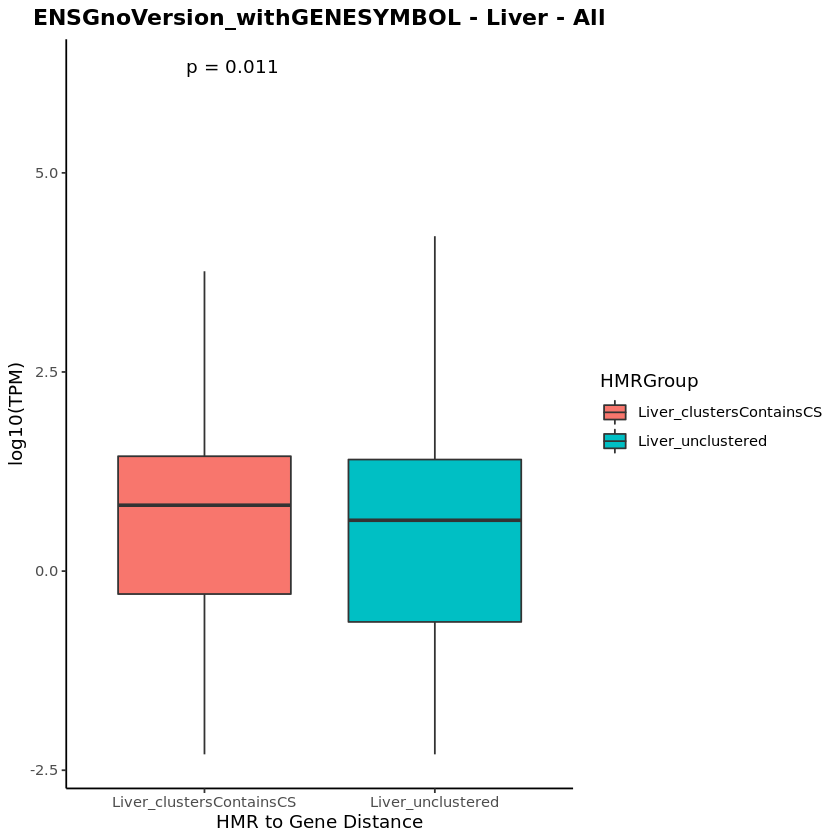

In [10]:
pdf("Liver.2NN.TAD.UniqueGenes.ALL.pdf")

pall <- ggplot(Liver_clustersContainsCS_Unclustered.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM.distBin, aes(x=HMRGroup, y=log10(TPM))) +
  geom_boxplot(aes(fill=HMRGroup)) +
  theme_classic() +
  ggtitle("ENSGnoVersion_withGENESYMBOL - Liver - All") +
  theme(plot.title = element_text(hjust = 0.5, face = "bold")) +
  xlab("HMR to Gene Distance") +
  ylab("log10(TPM)") +
  stat_compare_means(aes(group=HMRGroup), 
                     method="wilcox.test",  
                     method.args = list(alternative = "two.sided"),
                     label="p",
                     label.y=6.25)
pall

dev.off()
pall

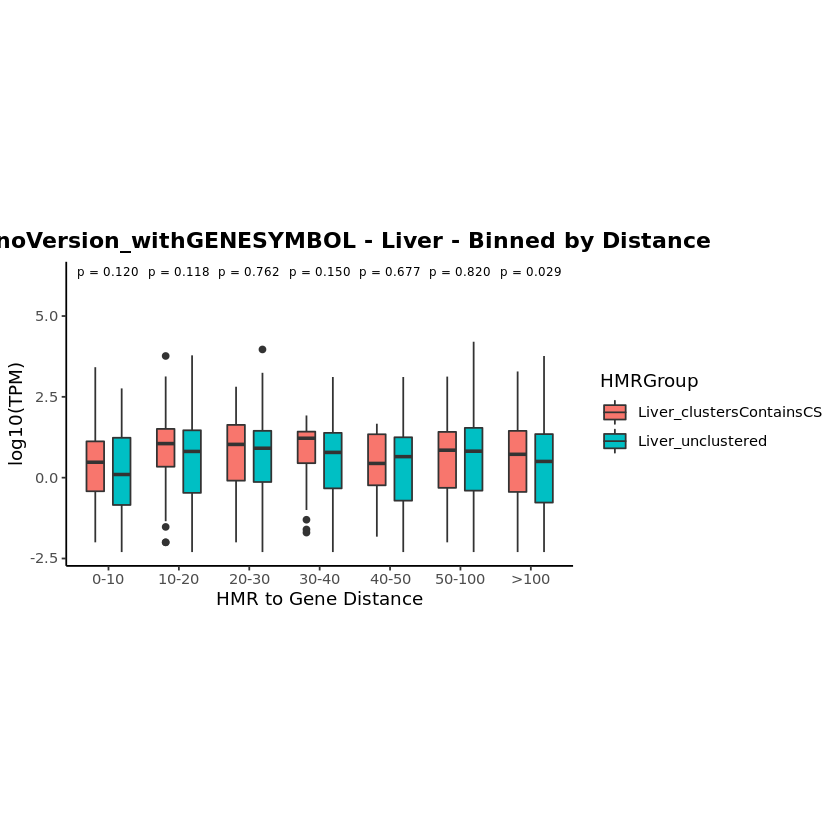

In [11]:
pdf("Liver.2NN.TAD.UniqueGenes.BINNED.pdf")

pbin <- ggplot(Liver_clustersContainsCS_Unclustered.2NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.uniqueENSGTSS_TPM.distBin, aes(x=distBin, y=log10(TPM))) +
  geom_boxplot(aes(fill=HMRGroup), width = .5, position=position_dodge(.75)) +
  theme_classic() +
  ggtitle("ENSGnoVersion_withGENESYMBOL - Liver - Binned by Distance") +
  theme(plot.title = element_text(hjust = 0.5, face = "bold")) +
  xlab("HMR to Gene Distance") +
  ylab("log10(TPM)") +
  stat_compare_means(aes(group=HMRGroup), 
                     method="wilcox.test",  
                     method.args = list(alternative = "two.sided"),
                     label="p",
                     label.y=6.25,
                    size = 2.5) +
  theme(aspect.ratio = .6)
pbin

dev.off()
pbin

# Plot fraction HMRs - 1 NN

## Find 100NN

In [1]:
HOME_DIR=/data/hodges_lab/Tim/nnRNA_TPM_EHGM/
mkdir -p ${HOME_DIR}
REF_DIR=${HOME_DIR}reference_files/

# Directory 
mkdir -p ${HOME_DIR}intermediate_files
cd ${HOME_DIR}intermediate_files

INTER_DIR=${HOME_DIR}intermediate_files/
REF_DIR=${HOME_DIR}reference_files/
OUT_DIR=${HOME_DIR}output_files/

echo "Done."

Done.


In [5]:
bedtools closest -d -k 100 -a ${INTER_DIR}Liver_internalClusters_hpl.containsCellSpecificHMR.tmp_sorted.txt -b ${REF_DIR}HepG2_ENSG_TPM_avg12_noVersion_hasHGNC_minTPM0.sorted.txt > ${INTER_DIR}Liver_clusters_containsCS.100NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.txt

echo "Done."

Done.


In [3]:
bedtools closest -d -k 100 -a ${INTER_DIR}Liver.unclustered_cs.tmp_sorted.txt -b ${REF_DIR}HepG2_ENSG_TPM_avg12_noVersion_hasHGNC_minTPM0.sorted.txt > ${INTER_DIR}Liver_unclustered_cellspecific.100NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.txt

echo "Done."

Done.


## TAD Filter

In [6]:
# Intersect 2NN file with TADs

# First, create an HMR-Gene end-to-end BED file:
#"ChrHMRProm","StartHMRProm","EndHMRProm","ChrHMR","StartHMR","EndHMR","ChrProm","StartProm","EndProm","ENSEMBL","TPM","HMRPromDist","HMRGroup"

# Check if HMR is before the TSS, else, TSS before  
awk 'BEGIN{OFS=FS="\t"}{if ($2<$6)
print $1,$2,$7,$1,$2,$3,$4,$5,$6,$7,$8,$9,$10,$11,$12;
else print $1,$6,$3,$1,$2,$3,$4,$5,$6,$7,$8,$9,$10,$11,$12;
}' ${INTER_DIR}Liver_clusters_containsCS.100NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.txt | awk 'BEGIN{OFS=FS="\t"}{if ($2!~/-1/) print}' - > ${INTER_DIR}Liver_clusters_containsCS.100NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.ContinuousBEDFormat.txt 

awk 'BEGIN{OFS=FS="\t"}{if ($2<$6)
print $1,$2,$7,$1,$2,$3,$4,$5,$6,$7,$8,$9,$10,$11,$12;
else print $1,$6,$3,$1,$2,$3,$4,$5,$6,$7,$8,$9,$10,$11,$12;
}' ${INTER_DIR}Liver_unclustered_cellspecific.100NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.txt | awk 'BEGIN{OFS=FS="\t"}{if ($2!~/-1/) print}' - > ${INTER_DIR}Liver_unclustered_cellspecific.100NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.ContinuousBEDFormat.txt

echo "Made continuous BED file."


Made continuous BED file.


In [8]:
bedtools intersect -f 1.0 -a ${INTER_DIR}Liver_clusters_containsCS.100NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.ContinuousBEDFormat.txt \
-b ${REF_DIR}Liver_STL011_Leung2015-raw_TADs.txt > ${INTER_DIR}Liver_clusters_containsCS.100NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.txt

bedtools intersect -f 1.0 -a ${INTER_DIR}Liver_unclustered_cellspecific.100NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.ContinuousBEDFormat.txt  \
-b ${REF_DIR}Liver_STL011_Leung2015-raw_TADs.txt > ${INTER_DIR}Liver_unclustered_cellspecific.100NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.txt

echo "Done."

Done.


## Filter down to 1NN per HMR

In [20]:
library(tidyverse)
library(ggplot2)
library(ggpubr)

#Set working directory 
setwd("/data/hodges_lab/Tim/nnRNA_TPM_EHGM/output_files/")

print("Loaded libraries.")

[1] "Loaded libraries."


In [21]:
Liver_clusters_containsCS <- read_tsv("/data/hodges_lab/Tim/nnRNA_TPM_EHGM/intermediate_files/Liver_internalClusters_hpl.containsCellSpecificHMR.txt", col_names = c("chr","start","end","numHMRs"))

Liver_unclustered_CS <- 
read_tsv("/data/hodges_lab/Tim/finalAnalyses_HMRs/hp_lineage/HMRs/Liver_unclustered_cellspecific_hpl.txt",  col_names = c("chr","start","end"))

Rows: 798 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): chr
dbl (3): start, end, numHMRs

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 5424 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): chr
dbl (2): start, end

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
Liver_clusters_containsCS %>% nrow()
Liver_unclustered_CS %>% nrow()

[1] 798

[1] 5424

In [22]:
Liver_clusters_containsCS.100NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered <- read_tsv("../intermediate_files/Liver_clusters_containsCS.100NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.txt", col_names=F) %>% magrittr::set_colnames(c("ChrHMRTSS","StartHMRTSS","EndHMRTSS","ChrHMR","StartHMR","EndHMR","HMRGroup","ChrTSS","StartTSS","EndTSS","TPM","strand","GENE_SYMBOL","ENSEMBL","HMRTSSDist")) 


Liver_unclustered_cellspecific.100NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered <- read_tsv("../intermediate_files/Liver_unclustered_cellspecific.100NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.txt", col_names=F) %>% magrittr::set_colnames(c("ChrHMRTSS","StartHMRTSS","EndHMRTSS","ChrHMR","StartHMR","EndHMR","HMRGroup","ChrTSS","StartTSS","EndTSS","TPM","strand","GENE_SYMBOL","ENSEMBL","HMRTSSDist"))

Rows: 4236 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): X1, X4, X7, X8, X13, X14
dbl (9): X2, X3, X5, X6, X9, X10, X11, X12, X15

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 18349 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): X1, X4, X7, X8, X13, X14
dbl (9): X2, X3, X5, X6, X9, X10, X11, X12, X15

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
Liver_clusters_containsCS.100NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered %>% nrow()

[1] 4236

In [9]:
Liver_clusters_containsCS.100NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered %>% group_by(ChrHMR, StartHMR) %>% top_n(n = 1, wt = -HMRTSSDist) %>% nrow()

[1] 381

In [34]:
Liver_clusters_containsCS.100NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.1NN <-Liver_clusters_containsCS.100NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered %>% 
group_by(ChrHMR, StartHMR) %>% # Group by each HMR
top_n(n = 1, wt = -HMRTSSDist) %>%  # Take top row by lowest Distance
top_n(n = 1, wt = TPM) %>%  # Might overlap two genes or have a tie in dist. Take top TPM
top_n(n = 1, wt = GENE_SYMBOL)  # Might still overlap two genes with same TPM (often 0TPM), so take first alphabetically

Liver_unclustered_cellspecific.100NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.1NN <-Liver_unclustered_cellspecific.100NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered %>% 
group_by(ChrHMR, StartHMR) %>% # Group by each HMR
top_n(n = 1, wt = -HMRTSSDist) %>%  # Take top row by lowest Distance
top_n(n = 1, wt = TPM) %>%  # Might overlap two genes or have a tie in dist. Take top TPM
top_n(n = 1, wt = GENE_SYMBOL)  # Might still overlap two genes with same TPM (often 0TPM), so take first alphabetically

In [49]:
Liver_unclustered_cellspecific.100NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered %>% 
group_by(ChrHMR, StartHMR) %>% # Group by each HMR
top_n(n = 1, wt = -HMRTSSDist) %>%  # Take top row by lowest Distance
top_n(n = 1, wt = TPM) %>%  # Might overlap two genes or have a tie in dist. Take top TPM
top_n(n = 1, wt = GENE_SYMBOL) %>% nrow()

[1] 2957

In [50]:
Liver_unclustered_cellspecific.100NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered %>% 
group_by(ChrHMR, StartHMR) %>% # Group by each HMR
top_n(n = 1, wt = -HMRTSSDist) %>%  nrow()

[1] 2957

## Calculate fractions

In [35]:
threshold_list <- c(10000,25000,50000,75000,100000,150000)

numGene_CLcontainsCS_1NN <- tibble(
    thresholds = threshold_list,
    HMRGroup = "Liver_clustersContainsCS"
)

numGene_UNCS_1NN <- tibble(
    thresholds = threshold_list,
    HMRGroup = "Liver_unclustered"
)


get_numGenes_per_threshold <- function(thresh, df){
    df %>% filter(HMRTSSDist < thresh) %>% nrow()
}
                                                    
print("Initialized.")

[1] "Initialized."


In [36]:
# Get numbers by threshold

# CLusters that contain Cell Specific 
CLcontainsCS_counts <- map(threshold_list, get_numGenes_per_threshold, df = Liver_clusters_containsCS.100NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.1NN)

numGene_CLcontainsCS_1NN$HMRCounts <- unlist(CLcontainsCS_counts)



# UNclustered Cell specific 
UNCS_counts <- map(threshold_list, get_numGenes_per_threshold, df = Liver_unclustered_cellspecific.100NN.HepG2_ENSGnoVersionGENESYMBOL_minTPM0.TAD_filtered.1NN)

numGene_UNCS_1NN$HMRCounts <- unlist(UNCS_counts)

print("Done.")

[1] "Done."


In [48]:
UNCS_counts

[[1]]
[1] 175

[[2]]
[1] 564

[[3]]
[1] 1027

[[4]]
[1] 1340

[[5]]
[1] 1558

[[6]]
[1] 1834

In [37]:
numGene_CLcontainsCS_1NN

thresholds,HMRGroup,HMRCounts
<dbl>,<chr>,<int>
10000,Liver_clustersContainsCS,83
25000,Liver_clustersContainsCS,146
50000,Liver_clustersContainsCS,207
75000,Liver_clustersContainsCS,236
100000,Liver_clustersContainsCS,260
150000,Liver_clustersContainsCS,297


In [47]:
numGene_UNCS_1NN

thresholds,HMRGroup,HMRCounts
<dbl>,<chr>,<int>
10000,Liver_unclustered,175
25000,Liver_unclustered,564
50000,Liver_unclustered,1027
75000,Liver_unclustered,1340
100000,Liver_unclustered,1558
150000,Liver_unclustered,1834


In [38]:
# Calc fraction
numGene_CLcontainsCS_1NN_fraction <- numGene_CLcontainsCS_1NN %>% mutate(fraction = (HMRCounts/798) )
numGene_UNCS_1NN_fraction <- numGene_UNCS_1NN %>% mutate(fraction = (HMRCounts/5424) )

numGene_CLcontainsCS_UNCS_1NN_fraction <- rbind(numGene_CLcontainsCS_1NN_fraction, numGene_UNCS_1NN_fraction)

print("Done.")

[1] "Done."


## Plot

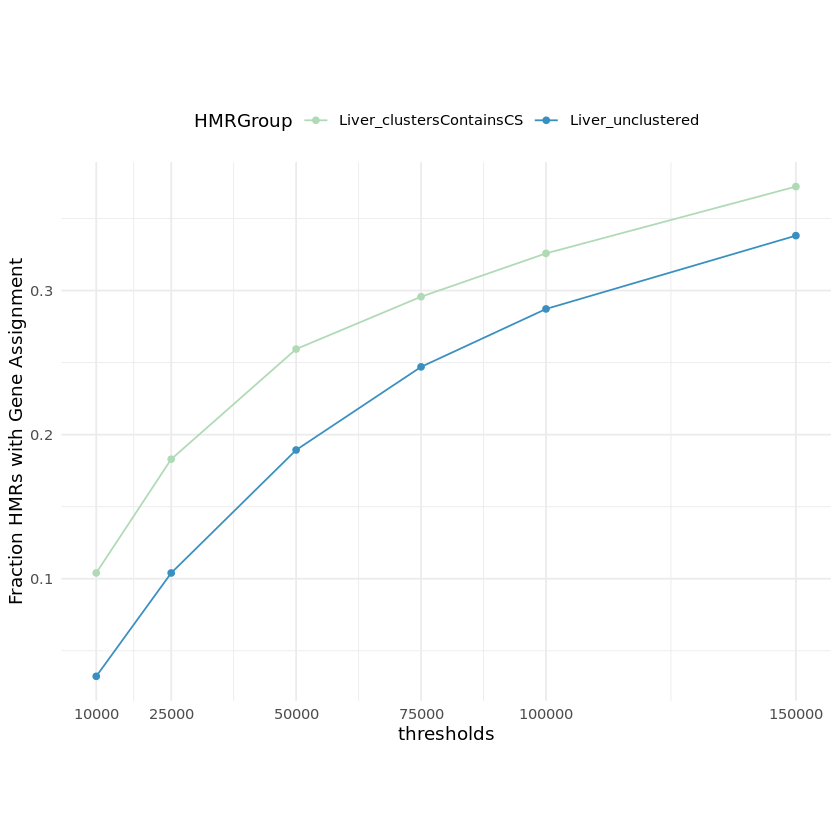

In [39]:
p_numGene_1NN <- numGene_CLcontainsCS_UNCS_1NN_fraction %>%
ggplot(aes(x = thresholds, y = fraction)) +
geom_point(aes(color = HMRGroup)) + 
geom_line(aes(color = HMRGroup)) +
theme_minimal() +
scale_color_manual(values=c("#B0DAB6", "#3990C0")) +
theme(aspect.ratio = .7, legend.position = "top") +
scale_x_continuous(breaks=threshold_list) +
ylab("Fraction HMRs with Gene Assignment")
p_numGene_1NN

In [ ]:
## Fraction of fractions

In [40]:
numGene_CLcontainsCS_UNCS_1NN_fractionRatio <- merge(numGene_CLcontainsCS_1NN_fraction, numGene_UNCS_1NN_fraction, by = "thresholds") %>% mutate(fractionRatio = (fraction.x/fraction.y))

In [41]:
numGene_CLcontainsCS_UNCS_1NN_fractionRatio

thresholds,HMRGroup.x,HMRCounts.x,fraction.x,HMRGroup.y,HMRCounts.y,fraction.y,fractionRatio
<dbl>,<chr>,<int>,<dbl>,<chr>,<int>,<dbl>,<dbl>
10000,Liver_clustersContainsCS,83,0.1040100,Liver_unclustered,175,0.03226401,3.223716
25000,Liver_clustersContainsCS,146,0.1829574,Liver_unclustered,564,0.10398230,1.759505
50000,Liver_clustersContainsCS,207,0.2593985,Liver_unclustered,1027,0.18934366,1.369988
75000,Liver_clustersContainsCS,236,0.2957393,Liver_unclustered,1340,0.24705015,1.197082
100000,Liver_clustersContainsCS,260,0.3258145,Liver_unclustered,1558,0.28724189,1.134286
150000,Liver_clustersContainsCS,297,0.3721805,Liver_unclustered,1834,0.33812684,1.100713


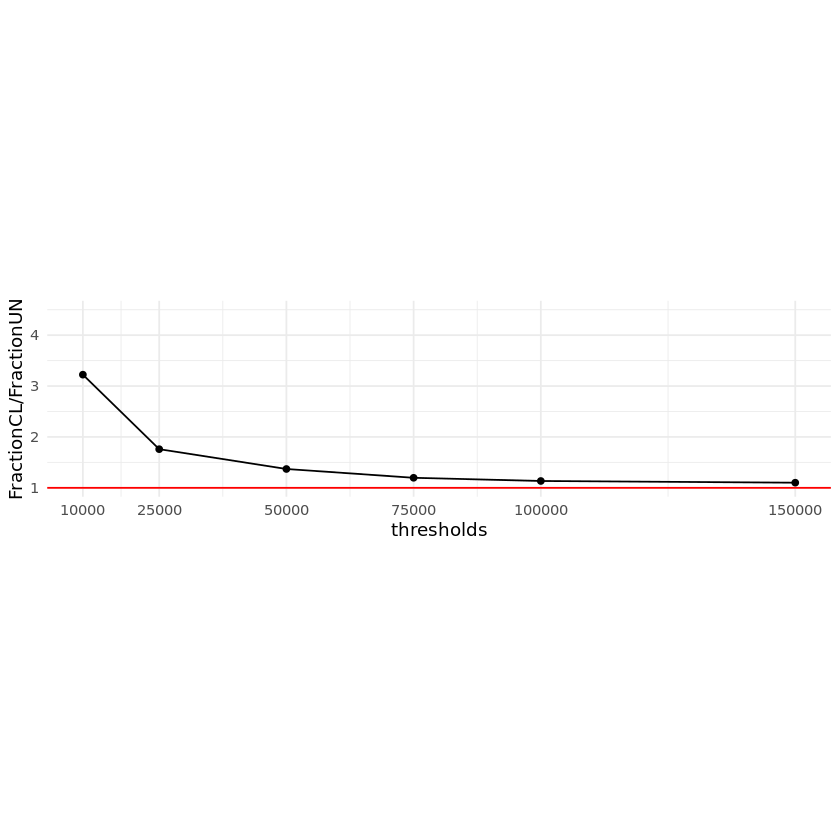

In [42]:
p_numGeneFraction_1NN <- numGene_CLcontainsCS_UNCS_1NN_fractionRatio %>% 
ggplot(aes(x = thresholds, y = fractionRatio)) +
geom_point() + 
geom_line() +
geom_hline(yintercept = 1, color = "red") + 
coord_cartesian(ylim = c(1,4.5)) +
theme_minimal() +
scale_x_continuous(breaks=threshold_list) + 
theme(aspect.ratio = .25) +
ylab("FractionCL/FractionUN")

p_numGeneFraction_1NN

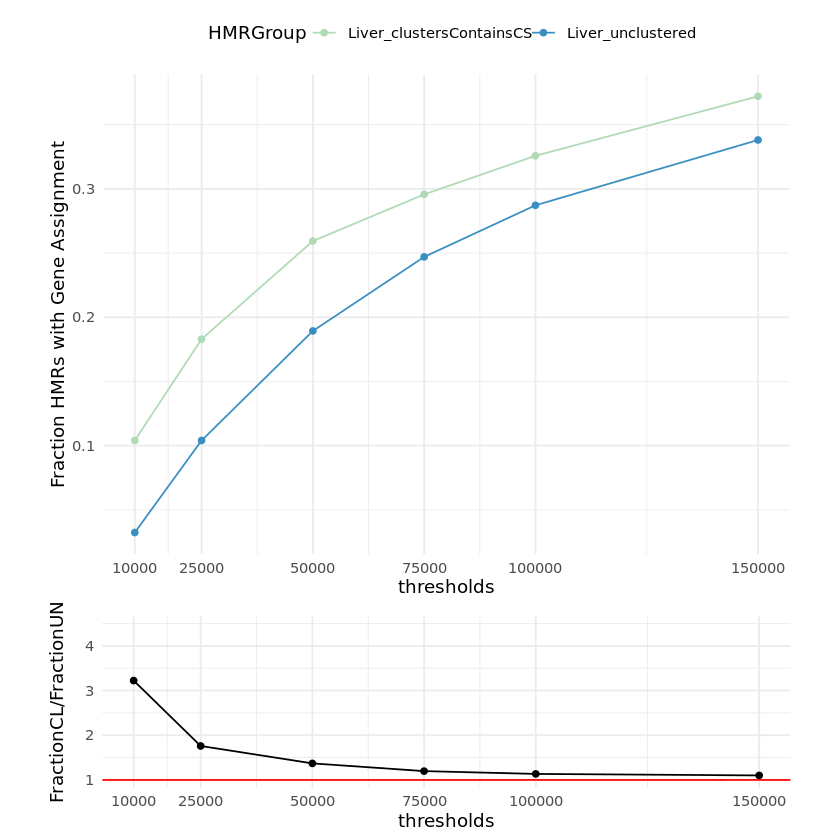

In [43]:
ggpubr::ggarrange(p_numGene_1NN, p_numGeneFraction_1NN, nrow = 2, align = "v", heights = c(4, 1.539))

## Stats for fractions

In [44]:
head(numGene_CLcontainsCS_UNCS_1NN_fractionRatio, 3)

,thresholds,HMRGroup.x,HMRCounts.x,fraction.x,HMRGroup.y,HMRCounts.y,fraction.y,fractionRatio
,<dbl>,<chr>,<int>,<dbl>,<chr>,<int>,<dbl>,<dbl>
1,10000,Liver_clustersContainsCS,83,0.1040100,Liver_unclustered,175,0.03226401,3.223716
2,25000,Liver_clustersContainsCS,146,0.1829574,Liver_unclustered,564,0.10398230,1.759505
3,50000,Liver_clustersContainsCS,207,0.2593985,Liver_unclustered,1027,0.18934366,1.369988


In [33]:
numGene_CLcontainsCS_UNCS_1NN_fractionRatio_pvals <- numGene_CLcontainsCS_UNCS_1NN_fractionRatio %>% rowwise() %>% mutate(
    propTestP = prop.test(x = c(HMRCounts.x, HMRCounts.y), n = c(798, 5424))$p.value,
    propTestStat = prop.test(x = c(HMRCounts.x, HMRCounts.y), n = c(798, 5424))$statistic,
)
numGene_CLcontainsCS_UNCS_1NN_fractionRatio_pvals

thresholds,HMRGroup.x,HMRCounts.x,fraction.x,HMRGroup.y,HMRCounts.y,fraction.y,fractionRatio,propTestP,propTestStat
<dbl>,<chr>,<int>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
10000,Liver_clustersContainsCS,83,0.1040100,Liver_unclustered,175,0.03226401,3.223716,5.633194e-21,88.296890
25000,Liver_clustersContainsCS,146,0.1829574,Liver_unclustered,564,0.10398230,1.759505,8.484266e-11,42.142871
50000,Liver_clustersContainsCS,207,0.2593985,Liver_unclustered,1027,0.18934366,1.369988,4.511161e-06,21.034377
75000,Liver_clustersContainsCS,236,0.2957393,Liver_unclustered,1340,0.24705015,1.197082,3.622866e-03,8.463788
100000,Liver_clustersContainsCS,260,0.3258145,Liver_unclustered,1558,0.28724189,1.134286,2.813396e-02,4.819840
150000,Liver_clustersContainsCS,297,0.3721805,Liver_unclustered,1834,0.33812684,1.100713,6.391721e-02,3.432708


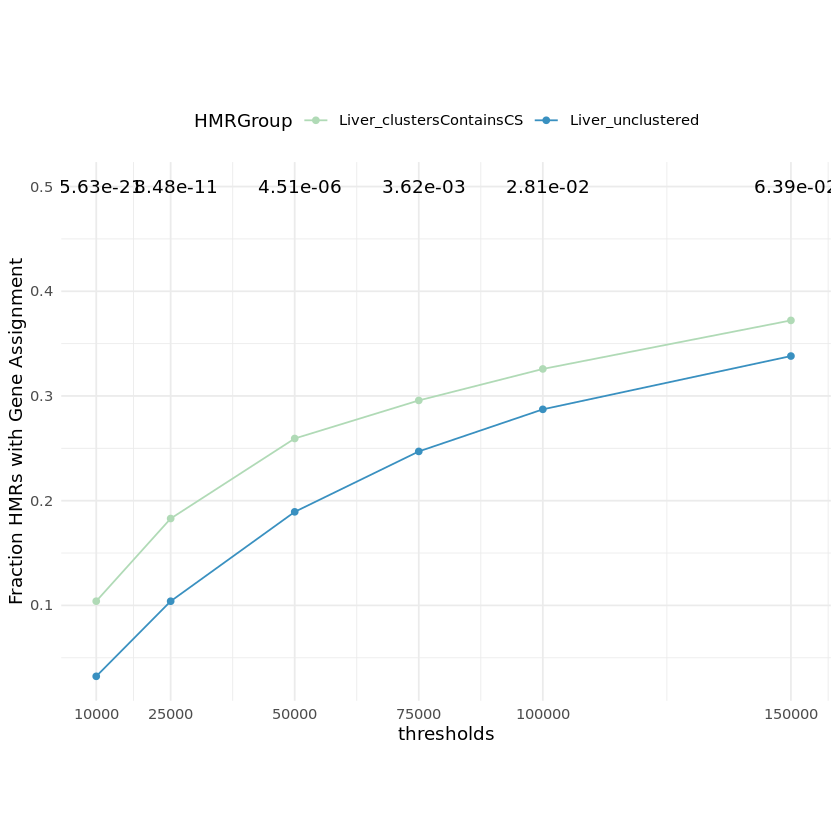

In [45]:
p_numGene_1NN_stats <- p_numGene_1NN +
geom_text(data = numGene_CLcontainsCS_UNCS_1NN_fractionRatio_pvals, aes(x = thresholds+1000, y = .5, label = format(propTestP, digits=3)))
p_numGene_1NN_stats

## Plot w/ stats

png 
  2

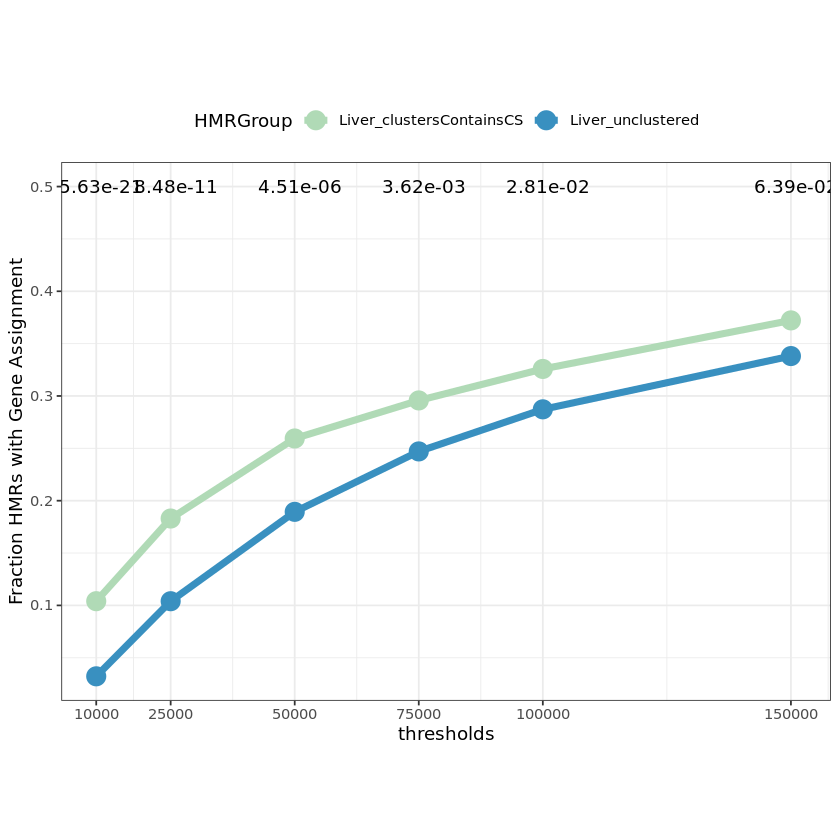

In [46]:
pdf("Liver.TAD.1NN.UniqueGenes.ProportionOfHMRsbyDistance.June11.pdf")

p_numGene_1NN_stats <- numGene_CLcontainsCS_UNCS_1NN_fraction %>%
ggplot(aes(x = thresholds, y = fraction)) +
geom_point(aes(color = HMRGroup), size = 5) + 
geom_line(aes(color = HMRGroup), size = 2) +
theme_bw() +
scale_color_manual(values=c("#B0DAB6", "#3990C0")) +
theme(aspect.ratio = .7, legend.position = "top") +
scale_x_continuous(breaks=threshold_list) +
ylab("Fraction HMRs with Gene Assignment") +
geom_text(data = numGene_CLcontainsCS_UNCS_1NN_fractionRatio_pvals, aes(x = thresholds+1000, y = .5, label = format(propTestP, digits=3)))
p_numGene_1NN_stats

dev.off()
p_numGene_1NN_stats

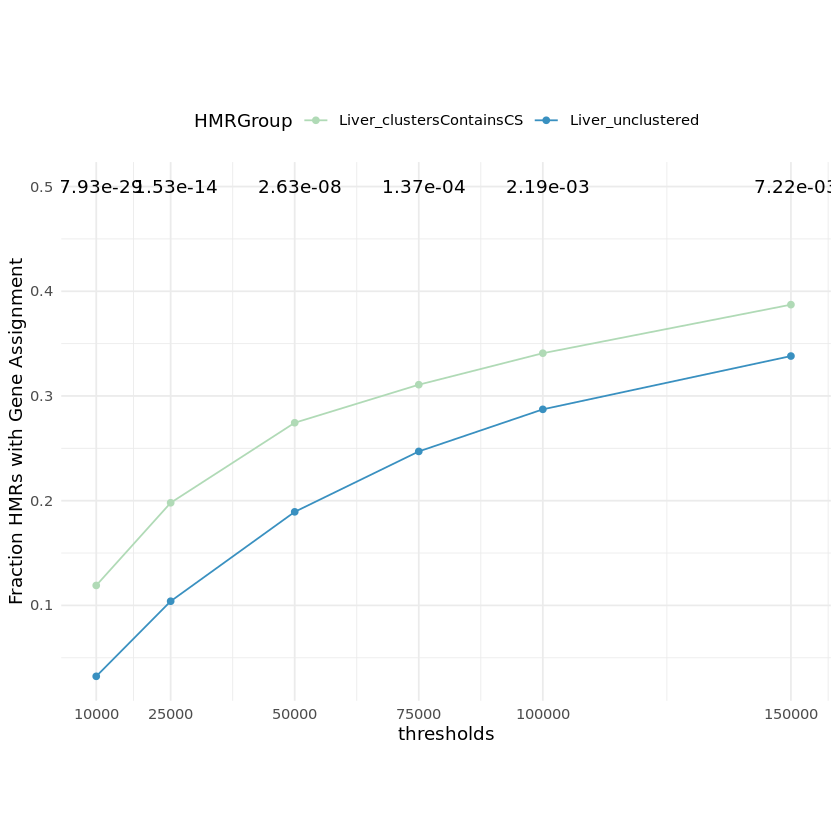

In [17]:
p_numGene_1NN_stats <- p_numGene_1NN +
geom_text(data = numGene_CLcontainsCS_UNCS_1NN_fractionRatio_pvals, aes(x = thresholds+1000, y = .5, label = format(propTestP, digits=3)))
p_numGene_1NN_stats

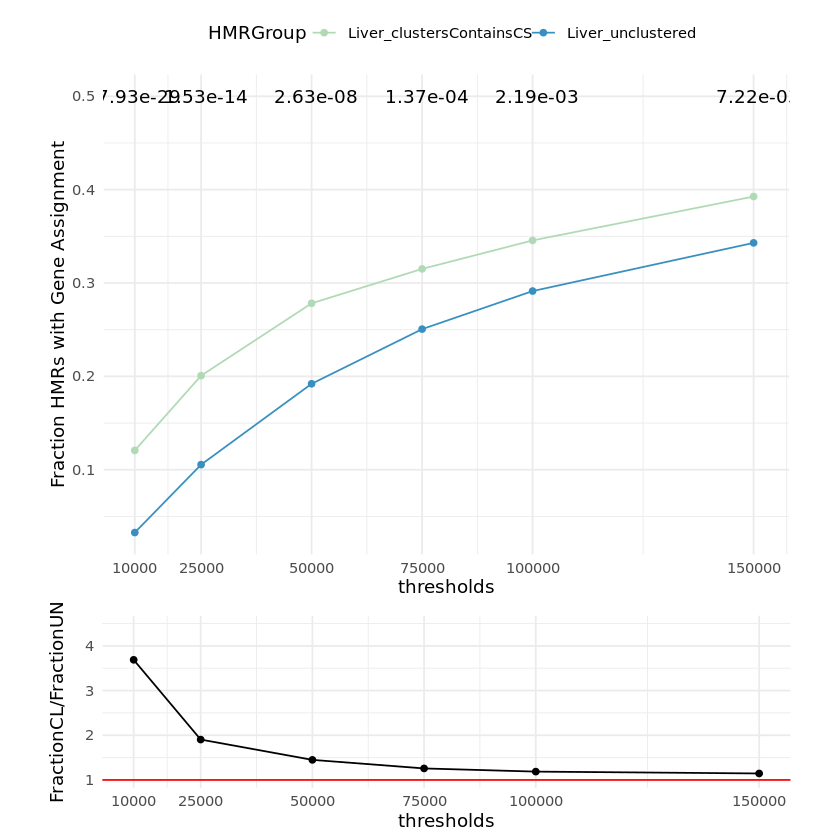

In [25]:
ggpubr::ggarrange(p_numGene_1NN_stats, p_numGeneFraction_1NN, nrow = 2, align = "v", heights = c(4, 1.539))